In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
from torch import nn  # nn contains all of PyTorch's building blocks for neural networks
from torch.utils.data import DataLoader # we need DataLoader to feed image into model
import matplotlib.pyplot as plt

from torchvision import datasets, transforms

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))


In [2]:
# helper function to show an image

def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

#### Configure the device to use GPU if available... and set the random state seed

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

device

device(type='cpu')

### First, we need to load our dataset and split it into train and test sets

In [35]:
### LOAD THE IMAGE DATA



transform = transforms.Compose([transforms.Resize((256,256)),
                                transforms.Grayscale(num_output_channels=1),
                                transforms.ToTensor()])
PATH = 'data'

TRAIN_PATH = PATH + '/train'
training_set = datasets.ImageFolder(TRAIN_PATH, transform=transform)
training_loader = DataLoader(training_set, batch_size=32, shuffle=True)

VAL_PATH = PATH + '/val'
validation_set = datasets.ImageFolder(VAL_PATH, transform=transform)
validation_loader = DataLoader(validation_set, batch_size=32, shuffle=True)

TEST_PATH = PATH + '/test'
testing_set = datasets.ImageFolder(TEST_PATH, transform=transform)
testing_loaer = DataLoader(testing_set, batch_size=32, shuffle=True)

torch.Size([1, 256, 256])

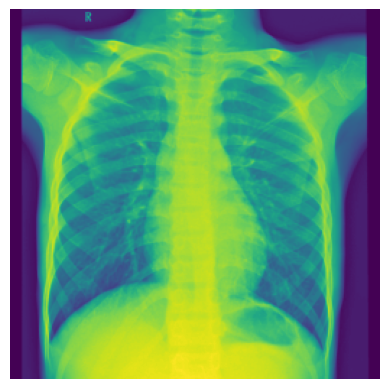

In [36]:
# Run this to test our training data loader
images, labels = next(iter(training_loader))
# helper.imshow(images[0], normalize=False)
imshow(images[0], normalize=False)
images[0].shape

### Let's do some EDA ###

In [39]:
# shape of the image batch and the labels batch
images.shape, labels.shape

(torch.Size([32, 1, 256, 256]), torch.Size([32]))

In [40]:
# Shape of datasets
print(f"Number of samples of training set: {len(training_set)}")
print(f"Number of samples of validation set: {len(validation_set)}")
print(f"Number of samples of test set: {len(testing_set)}")

Number of samples of training set: 13028
Number of samples of validation set: 761
Number of samples of test set: 1527


In [41]:
# Classes

unique_class = training_set.classes
unique_class

['NORMAL', 'PNEUMONIA', 'TUBERCULOSIS', 'UNKNOWN']

### Now we can start building our model. We will first build a simple baseline model, which will be used as a baseline to compare the results of later models to. We then will build more complex models to try to find the model with the best performance, which could include neural network models without/with non-linearity, CNNs and ResNet.

# 1. Build baseline model¶

## 1.1 Create a timer function

In [42]:
from timeit import default_timer as timer

def train_time(start: float, end: float, device: torch.device = None):

    total_time = end - start
    print(f"Train time on {device}: {total_time: .4f} seconds")

    return total_time

## 1.2 Baseline Model

In [43]:
class BaseModel0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = input_shape, out_features = hidden_units),
            nn.Linear(in_features = hidden_units, out_features = hidden_units),
            nn.Linear(in_features = hidden_units, out_features = output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)

In [45]:
baseModel = BaseModel0(input_shape = 256*256, hidden_units = 100, output_shape = len(unique_class))

baseModel.to(device)

BaseModel0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=65536, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Linear(in_features=100, out_features=4, bias=True)
  )
)

## 1.3 loss and optimizer

In [46]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = baseModel.parameters(), lr = 0.1)

## 1.4 Functionizing training and testing loops¶

In [48]:
def training(model: nn.Module,
            loader: torch.utils.data.DataLoader,
            loss_fn: nn.Module,
            optimizer: torch.optim.Optimizer,
            epoch: int,             
            device_on: torch.device = device):
    
    train_loss = 0

    model.to(device_on)

    for batch, (X,y) in enumerate(loader):

        X, y = X.to(device_on), y.to(device_on)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss+=loss

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    train_loss = train_loss/len(loader)
    if (epoch % 10 == 0):
        print(f"Epoch: {epoch} | Train Loss: {train_loss: .6f}")

def testing(loader: torch.utils.data.DataLoader,
           model: nn.Module,
           loss_fn: nn.Module,
           device_on: torch.device = device):

    test_loss = 0
    model.to(device)

    model.eval()

    with torch.inference_mode():
        for X, y in loader:
            X,y = X.to(device), y.to(device)

            test_pred = model(X)

            test_loss+=loss_fn(test_pred, y)

        test_loss /= len(loader)

        if (epoch % 10 == 0):
            print(f"Test Loss: {test_loss: .6f}")
    

## 1.5 Training and Testing¶

In [50]:
# torch.manual_seed(42)

# start_time = timer()

# epochs = 50

# for epoch in range(epochs):

#     training(baseModel, training_loader, loss_fn = loss,
#             optimizer = optimizer, epoch = epoch)

#     testing(testing_loader, baseModel, loss_fn = loss)

# end_time = timer()

# total_time = train_time(start_time, end_time, device = device)